In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
sys.path.append(parentdir)

from joblib import Parallel, delayed
import numpy as np
import pickle 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchmetrics
import seaborn as sns
import glob
from tqdm import tqdm
from copy import deepcopy
from src.transformer.metrics import AUL, CorrectedMCC, CorrectedBAcc, CorrectedF1
from src.analysis.metrics.cartesian import cartesian_jit

from torchmetrics import MatthewsCorrCoef, F1Score, Accuracy
from sklearn.utils import resample
from scipy.stats import median_abs_deviation as mad
import time
import cmcrameri.cm as cmc
import matplotlib.colors as clr
from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
plt.rcParams["grid.linestyle"] =  ":"
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.7

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"

#### Description
This notebook is used to evaluate the *Emigration* model.

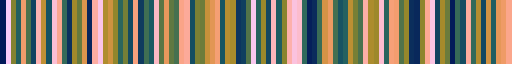

In [2]:
cmap = cmc.batlowS
cmap

In [3]:
v= "0.3"
save_path = r"O:/projekter/PY000017_D/analysis/plots/em/%s/" %v

In [4]:
def load_stats(path):
    data = {}
    with open(path + "prb.npy", "rb") as f:
        data["prb"] = np.load(f)
    with open(path + "trg.npy", "rb") as f:
        data["trg"] = np.load(f)
    with open(path + "id.npy", "rb") as f:
        data["id"] = np.load(f)
    return data
def metrics_parallel(metrics, preds, targs):
    return metrics(preds, targs).numpy()
def aul(prb_p, prb_a):
    score = 0
    for p in prb_p:
        score += (p > prb_a).sum()
    score += 0.5 * (p == prb_a).sum()
    n_pos = float(prb_p.shape[0])
    n = float(prb_a.shape[0])
    return score/(n_pos*n)

def return_aul(preds, targs):
    preds_p = preds[targs==1]
    return aul(preds_p, preds).item()
def return_mcc(preds, targs):
    metric = MatthewsCorrCoef(num_classes=2)
    return metric(preds, targs).numpy().item()

def return_acc(preds, targs):
    metric = Accuracy(num_classes=2, average="macro", multiclass=True)
    return metric(preds, targs).numpy().item()

def return_f1(preds, targs):
    metric = F1Score(num_classes=2, average="macro", multiclass=True)
    return metric(preds, targs).numpy().item()

def bootstrap_mcc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.015, alpha: float = 0.01, beta=1.0, only_scores = False):
    ids = np.arange(0, targs.shape[0], 1)
    
    idx = list()
    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    executor = Parallel(n_jobs=7)
    tasks = (delayed(metrics_parallel)(CorrectedMCC(alpha = alpha, beta= beta, threshold = 0.5, average="micro"), preds[i], targs[i]) for i in idx)
    scores = np.array(executor(tasks))
    #### on full dataset
    if only_scores:
        return scores
    metric = CorrectedMCC(alpha = alpha, beta= beta, threshold = 0.5, average="micro")
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_acc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.015, alpha: float = 0.01, beta=1.0, only_scores = False):
    ids = np.arange(0, targs.shape[0], 1)
    
    idx = list()
    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    executor = Parallel(n_jobs=7)
    tasks = (delayed(metrics_parallel)(CorrectedBAcc(alpha = alpha, beta= beta, threshold = 0.5, average="micro"), preds[i], targs[i]) for i in idx)
    scores = np.array(executor(tasks))
    #### on full dataset
    if only_scores:
        return scores
    metric = CorrectedBAcc(alpha = alpha, beta= beta, threshold = 0.5, average="micro")
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci/2), "upper": np.quantile(scores, 1-ci/2)}


def bootstrap_f1(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.015, alpha: float = 0.01, beta=1.0, only_scores = False):
    ids = np.arange(0, targs.shape[0], 1)
    
    idx = list()
    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    executor = Parallel(n_jobs=7)
    tasks = (delayed(metrics_parallel)(CorrectedF1(alpha = alpha, beta= beta, threshold = 0.5, average="micro"), preds[i], targs[i]) for i in idx)
    scores = np.array(executor(tasks))
    #### on full dataset
    if only_scores:
        return scores
    metric = CorrectedF1(alpha = alpha, beta = beta, threshold = 0.5, average="micro")
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci/2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_aul(preds, targs, seed: int = 2021, ci: float = 0.015, n_bootstraps: int = 1000, only_scores = False):
    ids = np.arange(0, targs.shape[0], 1)
    
    idx = list()
    for n in range(n_bootstraps):
        i = resample(ids, stratify=targs, random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    executor = Parallel(n_jobs=7)
    tasks = (delayed(return_aul)( preds[i], targs[i]) for i in idx)
    scores = np.array(executor(tasks))
    #### on full dataset
    if only_scores:
        return scores
    
    return {"mean": return_aul(preds, targs), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


def return_stats(path: str):
    x  = load_stats(path)
    start = time.time()
    x["aul"] = return_aul(preds = x["prb"],  
              targs = x["trg"]) 
             # n_bootstraps=5000)
    print("AUL is done: %.2f s" %(time.time()-start))
    print(x["aul"])
    start = time.time()
    x["mcc"] = bootstrap_mcc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=5000,
              alpha = 0.01,
              beta=1.0)
    print("MCC is done: %.2f s" %(time.time()-start))
    print(x["mcc"])

    start = time.time()
    x["acc"] = bootstrap_acc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=5000,
              alpha = 0.01,
              beta=1.0)
    print("ACC is done: %.2f s" %(time.time()-start))
    print(x["acc"])

    start = time.time()
    
    x["f1"] = bootstrap_f1(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=5000,
              alpha = 0.01,
              beta=1.0)
    print("F1 is done: %.2f s" %(time.time()-start))
    print(x["f1"])
    return x

def contains_in_sequence(sample, min_, max_):
    """Checks if sequence contains tokens in range [min_, max_]"""
    return np.where((sample >= min_) & (sample <=max_))[0].shape[0] > 0

In [5]:
data = {}

In [6]:
x = load_stats(r"O:\\projekter\\PY000017_D\\predictions\\v15\\emm\\emm_l2v\\%s\\"%v)

In [ ]:
%%time
data["l2v"] = return_stats(r"O:\\projekter\\PY000017_D\\predictions\\v15\\emm\\emm_l2v\\%s\\"%v)

In [9]:
data["rnn"] = return_stats(r"O:\\projekter\\PY000017_D\\predictions\\v15\\emm\\emm_rnn\\0.4\\")

AUL is done: 0.18 s
0.7855556945228684
MCC is done: 290.79 s
{'mean': 0.14360277354717255, 'lower': 0.13583215933293105, 'upper': 0.15133474387228493}
ACC is done: 287.64 s
{'mean': 0.7135048508644104, 'lower': 0.7019722487032414, 'upper': 0.7250932790338993}
F1 is done: 277.01 s
{'mean': 0.10683707892894745, 'lower': 0.1037857998907566, 'upper': 0.10985342999920251}


In [10]:
simple_baselines = True
if simple_baselines:
    np.random.seed(0)
    data["rnd"] = {"prb": np.random.uniform(size=data["rnn"]["trg"].shape[0]),
               "trg": data["rnn"]["trg"]}
    data["rnd"]["aul"] = return_aul(preds = data["rnd"]["prb"],  
                               targs = data["rnd"]["trg"])
    data["rnd"]["mcc"] = bootstrap_mcc(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,1
              alpha = 0.01,
              beta=1.0)
    data["rnd"]["acc"] = bootstrap_acc(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,
              alpha = 0.01,
              beta=1.0)
    data["rnd"]["f1"] = bootstrap_f1(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,
              alpha = 0.01,
              beta=1.0)


In [12]:
np.random.seed(0)
data["mjr"] = {"prb": np.random.uniform(high=0.5, size=data["rnn"]["trg"].shape[0]),
               "trg": data["rnn"]["trg"]}
data["mjr"]["aul"] = return_aul(preds = data["mjr"]["prb"],  
                               targs = data["mjr"]["trg"])
data["mjr"]["mcc"] = {"mean": return_mcc(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}
data["mjr"]["acc"] = {"mean": return_acc(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}
data["mjr"]["f1"] = {"mean": return_f1(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}

In [19]:
try:
    raise Error() 
    with open(save_path + "metric.pkl", "wb") as f:
        pickle.dump(data,f)
except:
    with open(save_path + "metric.pkl", "rb") as f:
        data = pickle.load(f)

In [ ]:
print("AUL")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["aul"]["mean"], 
                                           data[key]["aul"]["lower"], 
                                           data[key]["aul"]["upper"]))
print("MCC")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["mcc"]["mean"], 
                                           data[key]["mcc"]["lower"], 
                                           data[key]["mcc"]["upper"]))
print("ACC")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["acc"]["mean"], 
                                           data[key]["acc"]["lower"], 
                                           data[key]["acc"]["upper"]))
print("F1")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["f1"]["mean"], 
                                           data[key]["f1"]["lower"], 
                                           data[key]["f1"]["upper"]))